In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
from sklearn.model_selection import train_test_split
from pandasql import sqldf
import os
import h5py
import time
from datetime import timedelta
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [4]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()


# Load data
'''
W: operative conditions (Scenario descriptors): 작동조건
X_s: measured signals: 측정된 신호
X_v: virtual sensors: 가상 센서
T(theta): engine health parameters: 엔진 상태 매개변수
Y: RUL [in cycles]
A: auxiliary data: 보조 데이터
'''

'\nW: operative conditions (Scenario descriptors): 작동조건\nX_s: measured signals: 측정된 신호\nX_v: virtual sensors: 가상 센서\nT(theta): engine health parameters: 엔진 상태 매개변수\nY: RUL [in cycles]\nA: auxiliary data: 보조 데이터\n'

### Set-up - Define file location

In [25]:
# Get h5 filenames 함수
def get_h5_filenames(folder_path):
    h5_filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".h5"):
            h5_filenames.append(filename)
    return h5_filenames

# file derectory의 전체 파일 읽어서 filename 지정
current_dir = os.getcwd()
h5_filenames = get_h5_filenames(current_dir + "/raw_data")
h5_filenames.sort()
filename = "raw_data/"+h5_filenames[0]

with h5py.File(filename, 'r') as hdf:
        # Development(training) set
        W_dev = np.array(hdf.get('W_dev'))             # W 
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0)

print("Filename: ", filename)
print("Operation time (min): " , (time.process_time()-t)/60)
print ("number of training samples(timestamps): ", Y_dev.shape[0])
print ("number of testing  samples(timestamps): ", Y_test.shape[0])
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("Y shape: " + str(Y.shape))
print ("A shape: " + str(A.shape))

Filename:  raw_data/N-CMAPSS_DS01-005.h5
Operation time (min):  0.040752883333333344
number of training samples(timestamps):  4906636
number of testing  samples(timestamps):  2735232

W shape: (7641868, 4)
X_s shape: (7641868, 14)
X_v shape: (7641868, 14)
T shape: (7641868, 10)
Y shape: (7641868, 1)
A shape: (7641868, 4)


In [43]:
# df _ W, Xs, Y, A
df_W = DataFrame(data=W, columns=W_var)
df_Xs = DataFrame(data=X_s, columns=X_s_var)
df_Xv = DataFrame(data=X_v, columns=X_v_var)
df_T = DataFrame(data=T, columns=T_var)
df_Y = DataFrame(data=Y, columns=['RUL'])
df_A = DataFrame(data=A, columns=A_var)
# 각 feature가 'signalVariable, labelVariable, derivedVariable' 로 구분 필요_추후에 생각해보자

df_all = pd.concat([df_W, df_Xs, df_Xv, df_T, df_Y, df_A], axis=1)
df_all.columns

Index(['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2',
       'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30',
       'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan',
       'SmLPC', 'SmHPC', 'phi', 'fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod',
       'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod',
       'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'RUL', 'unit', 'cycle',
       'Fc', 'hs'],
      dtype='object')

In [44]:
# unit_list
unitList = [df_all['unit'].unique()]
print("unitList")
print(unitList)

unitList
[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])]


### mode_6 (HPT/DS01)

In [45]:
df_all.columns

Index(['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2',
       'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30',
       'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan',
       'SmLPC', 'SmHPC', 'phi', 'fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod',
       'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod',
       'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'RUL', 'unit', 'cycle',
       'Fc', 'hs'],
      dtype='object')

In [46]:
df_all.shape

(7641868, 47)

In [47]:
numUnit = 5
singleUnitData = df_all[df_all['unit'] == np.float64(numUnit)]
singleUnitData['unit']

2789639    5.0
2789640    5.0
2789641    5.0
2789642    5.0
2789643    5.0
          ... 
4069781    5.0
4069782    5.0
4069783    5.0
4069784    5.0
4069785    5.0
Name: unit, Length: 1280147, dtype: float64

In [ ]:
# HPT Temperature Drop vs. Flight Cycles
tempDiffData = (df_all['T40'] - df_all['T48']) / df_all['T40']
# Min-Max 정규화
def min_max_normalize(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

normalizedTempDiffData = min_max_normalize(tempDiffData)

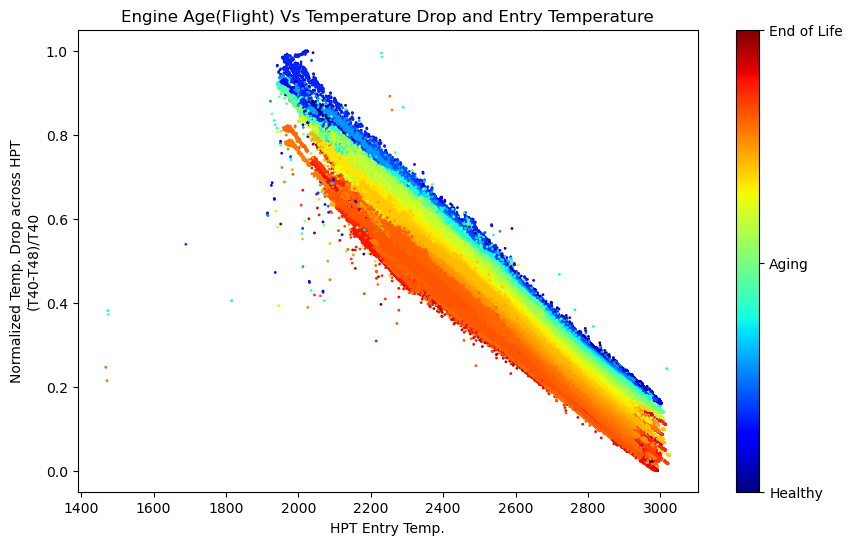

In [56]:
# Scatter plot 그리기 (색상은 Cycle 값에 따라 점차 변화)
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(df_all['T40'], normalizedTempDiffData, c=df_all['cycle'], 
                           cmap='jet', s = 1)
plt.xlabel('HPT Entry Temp.')
plt.ylabel('Normalized Temp. Drop across HPT\n(T40-T48)/T40')
plt.title('Engine Age(Flight) Vs Temperature Drop and Entry Temperature')

# 컬러바 추가 및 라벨 설정
cbar = plt.colorbar(scatter_plot)
minCycle = min(df_all['cycle'])
maxCycle = max(df_all['cycle'])
medCycle = (minCycle+maxCycle)//2
cbar.set_ticks([minCycle, medCycle, maxCycle]) # 컬러바 위치 지정 (최솟값과 최댓값)
cbar.set_ticklabels(['Healthy', 'Aging','End of Life']) # 컬러바 라벨 설정

plt.show()

### Mode_6 (LPT/DS07)

In [20]:
# LPT Temperature Drop vs. Flight Cycles
# tempDiffData = (df_all['T48'] - df_all['T50']) / df_all['T48']
# Min-Max 정규화
def min_max_normalize(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

normalizedTempDiffData = min_max_normalize(tempDiffData)

In [24]:
# HPT Pressure Ration vs. Flight Cycles
pressRatioData = df_all['P45']/ df_all['P40']
# pressRatioData = (df_all['P40']-df_all['P45'])/ df_all['P40']

# Min-Max 정규화
def min_max_normalize(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

normalizedPressRatioData = min_max_normalize(pressRatioData)

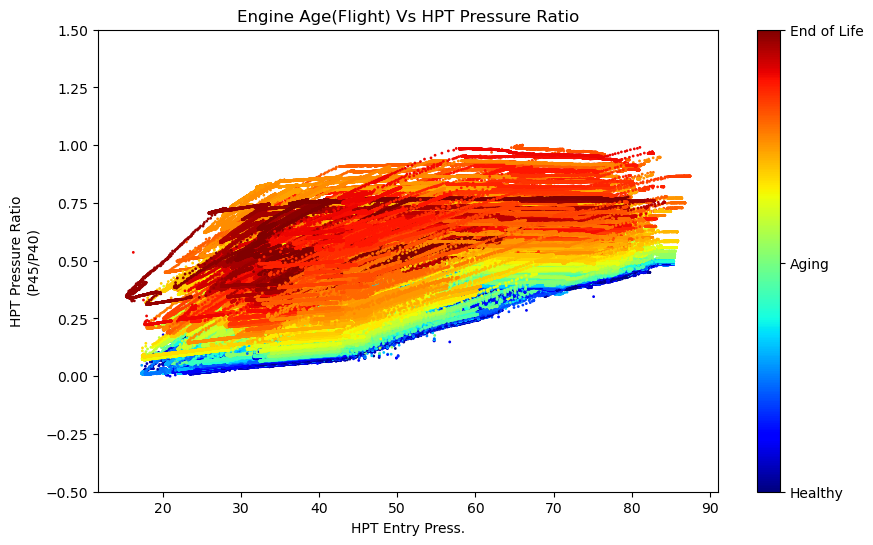

In [25]:
# Scatter plot 그리기 (색상은 Cycle 값에 따라 점차 변화)
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(df_all['P45'], normalizedPressRatioData, c=df_all['cycle'], 
                           cmap='jet', s = 1)
plt.xlabel('HPT Entry Press.')
plt.ylabel('HPT Pressure Ratio\n(P45/P40)')
plt.title('Engine Age(Flight) Vs HPT Pressure Ratio')

# 컬러바 추가 및 라벨 설정
cbar = plt.colorbar(scatter_plot)
minCycle = min(df_all['cycle'])
maxCycle = max(df_all['cycle'])
medCycle = (minCycle+maxCycle)//2
cbar.set_ticks([minCycle, medCycle, maxCycle]) # 컬러바 위치 지정 (최솟값과 최댓값)
cbar.set_ticklabels(['Healthy', 'Aging','End of Life']) # 컬러바 라벨 설정

# plt.xlim(-0.5, max_x + 1) # x축 범위 설정
plt.ylim(-0.5, +1.5) # y축 범위 설정

plt.show()

### mode_3 (Fan/DS04)

In [16]:
# Get h5 filenames 함수
def get_h5_filenames(folder_path):
    h5_filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".h5"):
            h5_filenames.append(filename)
    return h5_filenames

# file derectory의 전체 파일 읽어서 filename 지정
current_dir = os.getcwd()
h5_filenames = get_h5_filenames(current_dir + "/raw_data")
h5_filenames.sort()

filename = "raw_data/"+h5_filenames[3]

with h5py.File(filename, 'r') as hdf:
        # Development(training) set
        W_dev = np.array(hdf.get('W_dev'))             # W 
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0)

print("Filename: ", filename)
print("Operation time (min): " , (time.process_time()-t)/60)
print ("number of training samples(timestamps): ", Y_dev.shape[0])
print ("number of testing  samples(timestamps): ", Y_test.shape[0])
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("Y shape: " + str(Y.shape))
print ("A shape: " + str(A.shape))

# df _ W, Xs, Y, A
df_W = DataFrame(data=W, columns=W_var)
df_Xs = DataFrame(data=X_s, columns=X_s_var)
df_Xv = DataFrame(data=X_v, columns=X_v_var)
df_T = DataFrame(data=T, columns=T_var)
df_Y = DataFrame(data=Y, columns=['RUL'])
df_A = DataFrame(data=A, columns=A_var)
# 각 feature가 'signalVariable, labelVariable, derivedVariable' 로 구분 필요_추후에 생각해보자

df_all = pd.concat([df_W, df_Xs, df_Xv, df_T, df_Y, df_A], axis=1)

Filename:  raw_data/N-CMAPSS_DS04.h5
Operation time (min):  7.9382951833333335
number of training samples(timestamps):  6377452
number of testing  samples(timestamps):  3602561

W shape: (9980013, 4)
X_s shape: (9980013, 14)
X_v shape: (9980013, 14)
T shape: (9980013, 10)
Y shape: (9980013, 1)
A shape: (9980013, 4)


In [17]:
# fanStallMargin Ratio vs. Flight Cycles
fanStallMargin = df_all['SmFan'] / df_all['P21']

# Min-Max 정규화
def min_max_normalize(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

normalizedFanStallMargin = min_max_normalize(fanStallMargin)

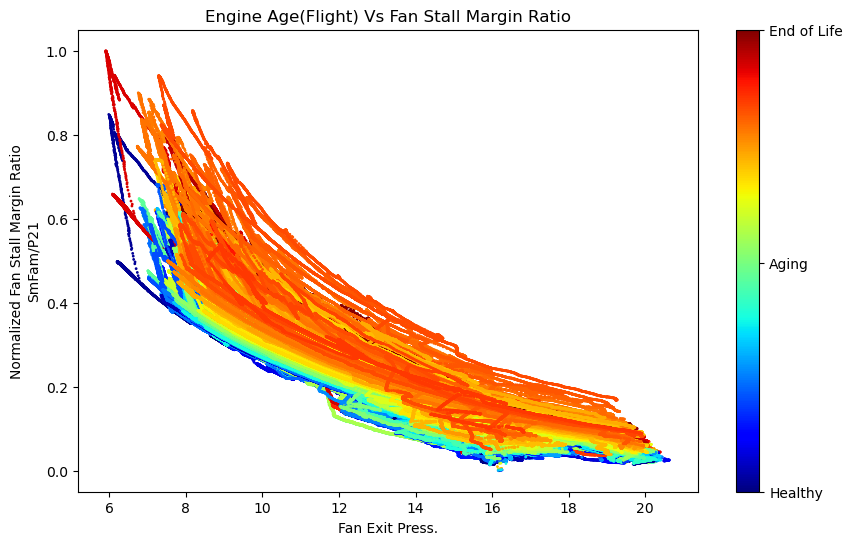

In [18]:
# Scatter plot 그리기 (색상은 Cycle 값에 따라 점차 변화)
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(df_all['P21'], normalizedFanStallMargin, c=df_all['cycle'], 
                           cmap='jet', s = 1)
plt.xlabel('Fan Exit Press.')
plt.ylabel('Normalized Fan Stall Margin Ratio\nSmFam/P21')
plt.title('Engine Age(Flight) Vs Fan Stall Margin Ratio')

# 컬러바 추가 및 라벨 설정
cbar = plt.colorbar(scatter_plot)
minCycle = min(df_all['cycle'])
maxCycle = max(df_all['cycle'])
medCycle = (minCycle+maxCycle)//2
cbar.set_ticks([minCycle, medCycle, maxCycle]) # 컬러바 위치 지정 (최솟값과 최댓값)
cbar.set_ticklabels(['Healthy', 'Aging','End of Life']) # 컬러바 라벨 설정

### mode_4 (HPC/DS05)

In [6]:
# Get h5 filenames 함수
def get_h5_filenames(folder_path):
    h5_filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".h5"):
            h5_filenames.append(filename)
    return h5_filenames

# file derectory의 전체 파일 읽어서 filename 지정
current_dir = os.getcwd()
h5_filenames = get_h5_filenames(current_dir + "/raw_data")
h5_filenames.sort()

filename = "raw_data/"+h5_filenames[4]

with h5py.File(filename, 'r') as hdf:
        # Development(training) set
        W_dev = np.array(hdf.get('W_dev'))             # W 
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0)

print("Filename: ", filename)
print("Operation time (min): " , (time.process_time()-t)/60)
print ("number of training samples(timestamps): ", Y_dev.shape[0])
print ("number of testing  samples(timestamps): ", Y_test.shape[0])
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("Y shape: " + str(Y.shape))
print ("A shape: " + str(A.shape))

# df _ W, Xs, Y, A
df_W = DataFrame(data=W, columns=W_var)
df_Xs = DataFrame(data=X_s, columns=X_s_var)
df_Xv = DataFrame(data=X_v, columns=X_v_var)
df_T = DataFrame(data=T, columns=T_var)
df_Y = DataFrame(data=Y, columns=['RUL'])
df_A = DataFrame(data=A, columns=A_var)
# 각 feature가 'signalVariable, labelVariable, derivedVariable' 로 구분 필요_추후에 생각해보자

df_all = pd.concat([df_W, df_Xs, df_Xv, df_T, df_Y, df_A], axis=1)

Filename:  raw_data/N-CMAPSS_DS05.h5
Operation time (min):  2.6321996166666666
number of training samples(timestamps):  4350606
number of testing  samples(timestamps):  2562046

W shape: (6912652, 4)
X_s shape: (6912652, 14)
X_v shape: (6912652, 14)
T shape: (6912652, 10)
Y shape: (6912652, 1)
A shape: (6912652, 4)


In [14]:
# fanStallMargin Ratio vs. Flight Cycles
smhpcRation = (df_all['SmHPC']) / df_all['Ps30']

# Min-Max 정규화
def min_max_normalize(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

normalizedSmhpcRation = min_max_normalize(smhpcRation)

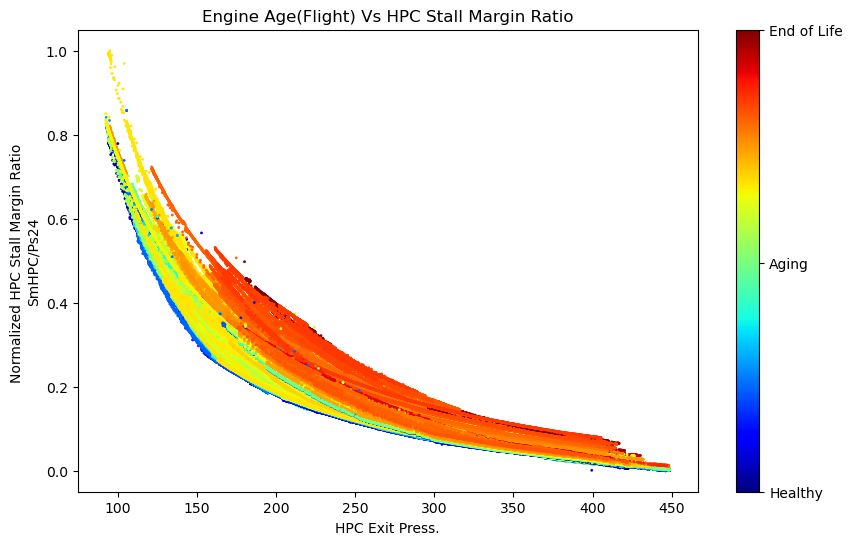

In [15]:
# Scatter plot 그리기 (색상은 Cycle 값에 따라 점차 변화)
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(df_all['Ps30'], normalizedSmhpcRation, c=df_all['cycle'], 
                           cmap='jet', s = 1)
plt.xlabel('HPC Exit Press.')
plt.ylabel('Normalized HPC Stall Margin Ratio \nSmHPC/Ps24')
plt.title('Engine Age(Flight) Vs HPC Stall Margin Ratio')

# 컬러바 추가 및 라벨 설정
cbar = plt.colorbar(scatter_plot)
minCycle = min(df_all['cycle'])
maxCycle = max(df_all['cycle'])
medCycle = (minCycle+maxCycle)//2
cbar.set_ticks([minCycle, medCycle, maxCycle]) # 컬러바 위치 지정 (최솟값과 최댓값)
cbar.set_ticklabels(['Healthy', 'Aging','End of Life']) # 컬러바 라벨 설정

### LPC (DS06)

In [5]:
# Get h5 filenames 함수
def get_h5_filenames(folder_path):
    h5_filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".h5"):
            h5_filenames.append(filename)
    return h5_filenames

# file derectory의 전체 파일 읽어서 filename 지정
current_dir = os.getcwd()
h5_filenames = get_h5_filenames(current_dir + "/raw_data")
h5_filenames.sort()

filename = "raw_data/"+h5_filenames[5]

with h5py.File(filename, 'r') as hdf:
        # Development(training) set
        W_dev = np.array(hdf.get('W_dev'))             # W 
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0)

print("Filename: ", filename)
print("Operation time (min): " , (time.process_time()-t)/60)
print ("number of training samples(timestamps): ", Y_dev.shape[0])
print ("number of testing  samples(timestamps): ", Y_test.shape[0])
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("Y shape: " + str(Y.shape))
print ("A shape: " + str(A.shape))

# df _ W, Xs, Y, A
df_W = DataFrame(data=W, columns=W_var)
df_Xs = DataFrame(data=X_s, columns=X_s_var)
df_Xv = DataFrame(data=X_v, columns=X_v_var)
df_T = DataFrame(data=T, columns=T_var)
df_Y = DataFrame(data=Y, columns=['RUL'])
df_A = DataFrame(data=A, columns=A_var)
# 각 feature가 'signalVariable, labelVariable, derivedVariable' 로 구분 필요_추후에 생각해보자

df_all = pd.concat([df_W, df_Xs, df_Xv, df_T, df_Y, df_A], axis=1)

Filename:  raw_data/N-CMAPSS_DS06.h5
Operation time (min):  0.03456621666666666
number of training samples(timestamps):  4257209
number of testing  samples(timestamps):  2522447

W shape: (6779656, 4)
X_s shape: (6779656, 14)
X_v shape: (6779656, 14)
T shape: (6779656, 10)
Y shape: (6779656, 1)
A shape: (6779656, 4)


In [21]:
# LPCStallMargin Ratio vs. Flight Cycles
# lpcStallMarginRatio =  df_all['SmLPC'] / (df_all['P24'])
# fanHpcDropRatio = (df_all['P24'] - df_all['Ps30']) / df_all['P24']
# lpcStallMarginRatio = df_all['SmLPC'] / df_all['P15']
# lpcInoutTempRatio = (df_all['T50']-df_all['T2'])/df_all['T50']
# lpcHpcTempDropRatio = (df_all['T48']-df_all['T2'])/df_all['T2']
lpcStallMarginRatio = df_all['SmLPC'] / df_all['T2']

# Min-Max 정규화
def min_max_normalize(series):
    min_value = series.min()
    max_value = series.max()
    normalized_series = (series - min_value) / (max_value - min_value)
    return normalized_series

normalizedlpcStallMarginRatio = min_max_normalize(lpcStallMarginRatio)

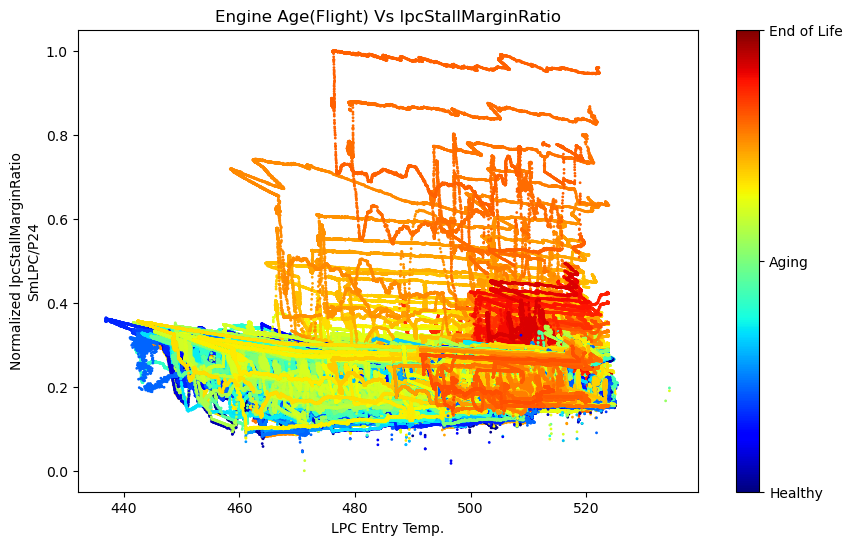

In [22]:
# Scatter plot 그리기 (색상은 Cycle 값에 따라 점차 변화)
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(df_all['T2'], normalizedlpcStallMarginRatio, c=df_all['cycle'], 
                           cmap='jet', s = 1)
plt.xlabel('LPC Entry Temp.')
plt.ylabel('Normalized lpcStallMarginRatio\nSmLPC/P24')
plt.title('Engine Age(Flight) Vs lpcStallMarginRatio')

# 컬러바 추가 및 라벨 설정
cbar = plt.colorbar(scatter_plot)
minCycle = min(df_all['cycle'])
maxCycle = max(df_all['cycle'])
medCycle = (minCycle+maxCycle)//2
cbar.set_ticks([minCycle, medCycle, maxCycle]) # 컬러바 위치 지정 (최솟값과 최댓값)
cbar.set_ticklabels(['Healthy', 'Aging','End of Life']) # 컬러바 라벨 설정